# Missing data patterns

Are there concerning patterns in missingness? In particular, does missingness change pre-post pandemic?

In [13]:
using DataFrames
using DataFramesMeta
using Plots
using StatsBase
using StatsModels
using Dates
using Plots.PlotMeasures
using GLM
using CSV
using CategoricalArrays
using Distributions
using Tables
using Revise
using LaTeXStrings


In [14]:
using KFactors

In [15]:
data = read_data("../data/peaks_merged.parquet", dropmissing=false)
nothing

┌ Info: Removing sensors days with peak-hour occ above 99th percentile (22.89%)
└ @ KFactors /Users/mwbc/git/peak-spreading/src/computation.jl:67


In [16]:
# filter to only the sensors present in all periods (should be 7743 unless there are sensors that are completely missing in some periods
data.period = KFactors.Periods.period_for_date.(data.date, Ref(KFactors.Periods.SPRING_2022))
sensors_in_all_periods = intersect(
    Set(unique(data[coalesce.((data.period .== :prepandemic), false) .&& (.!data.has_missing), :station])), 
    Set(unique(data[coalesce.((data.period .== :lockdown), false) .&& (.!data.has_missing), :station])), 
    Set(unique(data[coalesce.((data.period .== :postlockdown), false) .&& (.!data.has_missing), :station])), 
)

@assert length(sensors_in_all_periods) == 7743

data = data[data.station .∈ Ref(sensors_in_all_periods) .&& .!ismissing.(data.period), :]
nrow(data)

1942088

## Reasons for missingness

There are multiple ways data can be missing:
1. It can have small gaps that are imputed (e.g. because the modem failed to upload for a few minutes)
2. It can have large gaps or full days that are imputed
3. There can be insufficient data - we don't complete or imputed records for the full sensor day
4. There can be no traffic
5. (handled below) The sensor could not be in the file for that day, though it appears in other files

In [17]:
data[!, :missing_reason] .= :not_missing
data[data.periods_imputed .> 0, :missing_reason] .= :imputed_less_than_1hr
data[data.periods_imputed .>= 12, :missing_reason] .= :imputed_1hr_or_more
data[ismissing.(data.peak_hour_occ), :missing_reason] .= :insufficient_data
data[coalesce.(data.total_occ .== 0, [false]), :missing_reason] .= :no_traffic

nothing

In [18]:
# expand the data frame to include all sensor/day combinations
sensors = unique(data.station)
dates = unique(data.date)
sensor_days = reshape(collect(Iterators.product(sensors, dates)), :)
sensor_df = DataFrame(station=map(x -> x[1], sensor_days), date=map(x -> x[2], sensor_days))
nothing
data = leftjoin(sensor_df, data, on=[:station, :date])

,station,date,peak_hour_occ,peak_hour_occ_avg,peak_hour_flow,peak_hour_demand
,Int64,Date,Float64?,Float64?,Float64?,Float64?
1,312010,2016-02-17,0.134762,0.364158,0.0351875,0.0765258
2,312098,2016-02-17,0.0936754,0.188375,0.0565509,0.0631433
3,312103,2016-02-17,0.113312,0.272917,0.0636459,0.0824705
4,312132,2016-02-17,0.0778201,0.0816333,0.0859421,0.088392
5,312133,2016-02-17,0.283643,0.3765,0.0791283,0.123033
6,312134,2016-02-17,0.0742908,0.0820833,0.0736952,0.0736952
7,312139,2016-02-17,0.105445,0.348317,0.0552882,0.0919537
8,312326,2016-02-17,0.0875532,0.0480083,0.0966536,0.0966536
9,312346,2016-02-17,0.079661,0.10245,0.0741977,0.0754064


In [19]:
data[ismissing.(data.missing_reason), :missing_reason] .= :not_in_file
nothing

In [20]:
countmap(data.missing_reason)

Dict{Union{Missing, Symbol}, Int64} with 6 entries:
  :imputed_less_than_1hr => 212276
  :not_missing           => 731555
  :insufficient_data     => 27769
  :not_in_file           => 86578
  :imputed_1hr_or_more   => 969436
  :no_traffic            => 1052

## Temporal patterns in missingness

Did the reasons why data was missing change over the study period? Note that the plot only shows the active study period in each year.

In [21]:
# temporal patterns in missingness
temporal_missingness = combine(groupby(data[.!ismissing.(data.period), :], :date),
    :missing_reason => (x -> mean(x .== :imputed_less_than_1hr) * 100) => :pct_sensors_imputed_less_than_1hr,
    :missing_reason => (x -> mean(x .== :imputed_1hr_or_more) * 100) => :pct_sensors_imputed_1hr_or_more,
    :missing_reason => (x -> mean(x .== :no_traffic) * 100) => :pct_sensors_no_traffic,
    :missing_reason => (x -> mean(x .== :insufficient_data) * 100) => :pct_sensors_insufficient_data,
    :missing_reason => (x -> mean(x .== :not_in_file) * 100) => :pct_sensors_not_in_file,
    :missing_reason => (x -> mean(x .== :not_missing) * 100) => :pct_sensors_not_missing
)
sort!(temporal_missingness, :date)
nothing

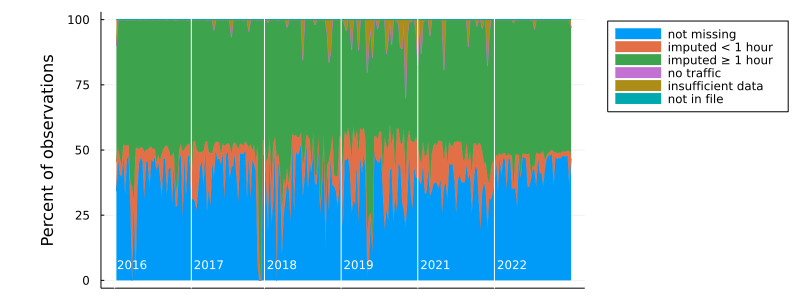

In [22]:
areaplot(1:nrow(temporal_missingness),
    hcat(
        temporal_missingness.pct_sensors_not_missing,
        temporal_missingness.pct_sensors_imputed_less_than_1hr,
        temporal_missingness.pct_sensors_imputed_1hr_or_more,
        temporal_missingness.pct_sensors_no_traffic,
        temporal_missingness.pct_sensors_insufficient_data,
        temporal_missingness.pct_sensors_not_in_file
    ),
    label=["not missing" "imputed < 1 hour" "imputed ≥ 1 hour" "no traffic" "insufficient data" "not in file"],
    legend=:outertopright,
    xticks=false,
    ylabel="Percent of observations",
    size=(800, 300),
    left_margin=50px
)

year_boundaries = map([2016, 2017, 2018, 2019, 2021, 2022]) do y
    return sum(temporal_missingness.date .< Date(y, 1, 1))
end
        
vline!(year_boundaries, color=:white, label=false)
annotate!(zip(year_boundaries .+ 10, fill(6, 6), map([2016, 2017, 2018, 2019, 2021, 2022]) do y 
            text(y, :white, :hcenter, pointsize=8)
        end)...)

savefig("../fig/sensor_missingness.pdf")
plot!()

In [23]:
combine(groupby(data, :missing_reason), x -> nrow(x) / nrow(data))

,missing_reason,x1
,Symbol?,Float64
1,not_missing,0.360609
2,imputed_1hr_or_more,0.477869
3,imputed_less_than_1hr,0.104638
4,insufficient_data,0.0136883
5,no_traffic,0.000518567
6,not_in_file,0.0426773


## Logistic regression model

We're doing a hypothesis test that spatial and temporal patterns did not change prepandemic to postpandemic by running a logistic regression with day of week, month, and county-road-direction fixed effects, and interacting them all with "postpandemic". Then we'll do a false discovery rate to see if the spatial/temporal pattern has changed.

In [24]:
# patch up that periods, locations, directions are missing for new dates
meta = CSV.read("../data/sensor_meta_geo.csv", DataFrame)
data.period = KFactors.Periods.period_for_date.(data.date, Ref(KFactors.Periods.SPRING_2022))
model_data = data[data.period .!= :lockdown, :]
select!(model_data, Not([:District, :urban, :Latitude, :Longitude, :direction, :Lanes]))
select!(meta, [:ID, :District, :urban, :Latitude, :Longitude, :County, :Dir, :Lanes, :Fwy])
model_data = leftjoin(model_data, meta, on=:station=>:ID)
@assert !any(ismissing.(model_data.Latitude))
nothing

In [27]:
model_data.fwy_dir_group = @with model_data categorical(string.(:Fwy) .* "_" .* :Dir .* "_" .*
    string.(:County) .* "_" .* ifelse.(model_data.urban, ["urban"], ["not_urban"]))
model_data.Lanes = categorical(model_data.Lanes)
model_data.dayofweek = categorical(Dates.dayname.(model_data.date))
model_data.month = categorical(Dates.monthname.(model_data.date))
model_data.anymissing = model_data.missing_reason .!= :not_missing
model_data.postlockdown = model_data.period .== :postlockdown
nothing

In [28]:
mean(model_data.missing_reason .!= :not_missing)

0.638914461952613

In [29]:
@assert !any(ismissing.(model_data.missing_reason))

In [30]:
# leaving year out due to collinearity with postpandemic, and also we don't differentiate prepandemic years in permutation test
logit = glm(@formula(anymissing ~ postlockdown*(fwy_dir_group + dayofweek + month)), model_data, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

anymissing ~ 1 + postlockdown + fwy_dir_group + dayofweek + month + postlockdown & fwy_dir_group + postlockdown & dayofweek + postlockdown & month

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                          Coef.   Std. Error       z  Pr(>|z|)      Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                                         -0.355162     0.0411874    -8.62    <1e-17   -0.435888     -0.274436
postlockdown                                         2.89844      0.167153     17.34    <1e-66    2.57083       3.22606
fwy_dir_group: 

In [31]:
tvals = coef(logit) ./ stderror(logit)
# TODO n-p-1 dof is correct yeah?
tdist = Distributions.TDist(nrow(model_data) - length(tvals) - 1)
pvals = (1 .- cdf.([tdist], abs.(tvals))) .* 2
# exclude the postpandemic main effect, we only care if spatial/temporal patterns changed
relevant_pvals = pvals[startswith.(coefnames(logit), ["postlockdown &"])]
nothing

### Multiple testing corrections

First, a simple Bonferroni correction.

In [32]:
mean(relevant_pvals .< 0.05 / length(relevant_pvals))

0.8126232741617357

### False discovery rate

Calculate the number of postpandemic interaction terms that are statistically significant, accounting for multiple-testing bias using a false discovery rate (Benjamini and Hochberg, 1995).

Not looking at the postpandemic base effect—we know the sensors got better. I think what we really care about is the distribution, although the overall base-rate change could affect analysis if the imputations are systematically biased.

In [33]:
# this is counting the number of p-values that are statistically significant with a FDR of 0.05
# from the FDR paper: Benjamini and Hochberg 1995
function false_discovery_rate(model, fdr; subset=nothing)
    if isnothing(subset)
       subset = coefnames(model)
    end
    
    selector = in.(coefnames(model), [Set(subset)])
    
    tvals = coef(model) ./ stderror(model)
    # TODO n-p-1 dof is correct yeah?
    tdist = Distributions.TDist(nobs(model) - length(tvals) - 1)
    pvals = (1 .- cdf.([tdist], abs.(tvals))) .* 2
    # exclude the postpandemic main effect, we only care if spatial/temporal patterns changed
    relevant_pvals = pvals[selector]
    relevant_coefnames = coefnames(model)[selector]
    pval_sort = sortperm(relevant_pvals)
    
    # "let k be the largest i for which P(i) ≤ i / m * q*" - Benjamini and Hochberg
    # julia uses 1-based indexing like Benjamini and Hochberg
    sig = relevant_pvals[pval_sort] .≤ (((1:length(relevant_pvals)) ./ length(relevant_pvals)) .* fdr)
    
    if !any(sig)
        return []
    end
    
    last_sig = findlast(x -> x, sig)
    
    # "then reject all [null hypotheses] H(i), i = 1, 2, ..., k
    sig[1:last_sig] .= true
    
    return relevant_coefnames[pval_sort][sig]
end

false_discovery_rate (generic function with 1 method)

In [34]:
fdrp = false_discovery_rate(logit, 0.05, subset=filter(c -> startswith(c, "postlockdown &"), coefnames(logit)))

422-element Vector{String}:
 "postlockdown & fwy_dir_group: 101_N_41_not_urban"
 "postlockdown & fwy_dir_group: 101_N_41_urban"
 "postlockdown & fwy_dir_group: 101_N_53_not_urban"
 "postlockdown & fwy_dir_group: 101_N_53_urban"
 "postlockdown & fwy_dir_group: 101_N_75_urban"
 "postlockdown & fwy_dir_group: 101_N_79_not_urban"
 "postlockdown & fwy_dir_group: 101_N_79_urban"
 "postlockdown & fwy_dir_group: 101_N_81_urban"
 "postlockdown & fwy_dir_group: 101_N_83_urban"
 "postlockdown & fwy_dir_group: 101_N_85_not_urban"
 "postlockdown & fwy_dir_group: 101_N_85_urban"
 "postlockdown & fwy_dir_group: 101_N_97_not_urban"
 "postlockdown & fwy_dir_group: 101_N_97_urban"
 ⋮
 "postlockdown & fwy_dir_group: 99_N_47_urban"
 "postlockdown & fwy_dir_group: 110_S_37_urban"
 "postlockdown & fwy_dir_group: 14_S_37_not_urban"
 "postlockdown & fwy_dir_group: 580_W_13_not_urban"
 "postlockdown & fwy_dir_group: 25_N_85_urban"
 "postlockdown & fwy_dir_group: 580_W_41_urban"
 "postlockdown & fwy_dir_group: 

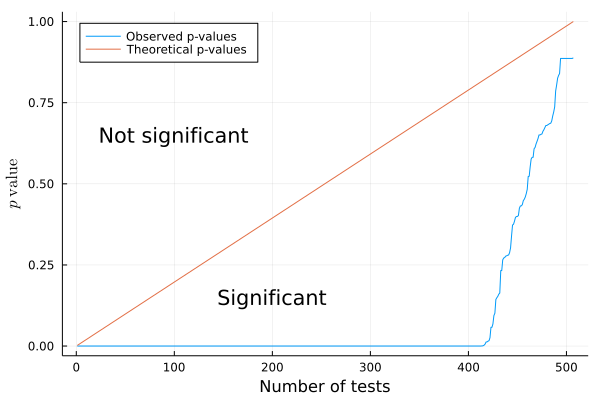

In [35]:
plot(1:length(relevant_pvals), sort(relevant_pvals), label="Observed p-values",
    legend=:topleft,
    xlab="Number of tests",
    ylab=L"p~\mathrm{value}"
)
plot!(1:length(relevant_pvals), (1:length(relevant_pvals)) ./ length(relevant_pvals), label="Theoretical p-values")
annotate!(
    (200, 0.15, "Significant"),
    (100, 0.65, "Not significant")
    )
savefig("../fig/pvals.pdf")
plot!()

### Practical significance

There's definitely statistical significance, but are the variables practically significant? Plot the distribution of odds ratios.

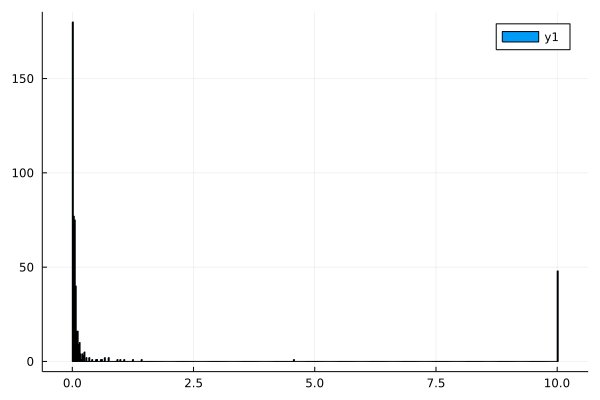

In [57]:
ors = exp.(coef(logit)[startswith.(coefnames(logit), ["postlockdown &"])])
histogram(ifelse.(ors .≥ 10, [10], ors))

In [75]:
quantile(ors, [0.05, 0.95])

2-element Vector{Float64}:
   0.00048152000380235024
 745.571398444444

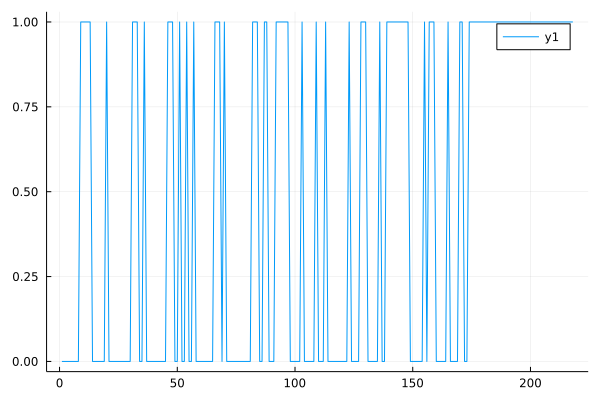

In [79]:
pd = model_data[model_data.fwy_dir_group .== "101_N_37_not_urban", :anymissing]
plot(1:length(pd), pd)

In [48]:
pvdf = DataFrame(Dict(:coef=>coefnames(logit), :p=>pvals))
rel_pvdf = pvdf[startswith.(pvdf.coef, Ref("postlockdown & fwy")), :]
rel_pvdf.fwy_dir_group = map(x -> replace(x, r"^.* "=>""), rel_pvdf.coef)

501-element Vector{String}:
 "101_N_37_not_urban"
 "101_N_37_urban"
 "101_N_41_not_urban"
 "101_N_41_urban"
 "101_N_53_not_urban"
 "101_N_53_urban"
 "101_N_75_urban"
 "101_N_79_not_urban"
 "101_N_79_urban"
 "101_N_81_urban"
 "101_N_83_not_urban"
 "101_N_83_urban"
 "101_N_85_not_urban"
 ⋮
 "99_S_29_not_urban"
 "99_S_29_urban"
 "99_S_39_not_urban"
 "99_S_39_urban"
 "99_S_47_not_urban"
 "99_S_47_urban"
 "99_S_67_not_urban"
 "99_S_67_urban"
 "99_S_77_not_urban"
 "99_S_77_urban"
 "99_S_99_not_urban"
 "99_S_99_urban"

In [52]:
sensors_per_group = combine(groupby(model_data, :fwy_dir_group), :station => length ∘ unique => :n_stations);
sensors_per_group = leftjoin(sensors_per_group, rel_pvdf, on=:fwy_dir_group)

,fwy_dir_group,n_stations,coef
,Cat…,Int64,String?
1,101_N_37_not_urban,1,postlockdown & fwy_dir_group: 101_N_37_not_urban
2,101_N_37_urban,70,postlockdown & fwy_dir_group: 101_N_37_urban
3,101_N_41_not_urban,8,postlockdown & fwy_dir_group: 101_N_41_not_urban
4,101_N_41_urban,51,postlockdown & fwy_dir_group: 101_N_41_urban
5,101_N_53_not_urban,2,postlockdown & fwy_dir_group: 101_N_53_not_urban
6,101_N_53_urban,2,postlockdown & fwy_dir_group: 101_N_53_urban
7,101_N_75_urban,11,postlockdown & fwy_dir_group: 101_N_75_urban
8,101_N_79_not_urban,8,postlockdown & fwy_dir_group: 101_N_79_not_urban
9,101_N_79_urban,29,postlockdown & fwy_dir_group: 101_N_79_urban


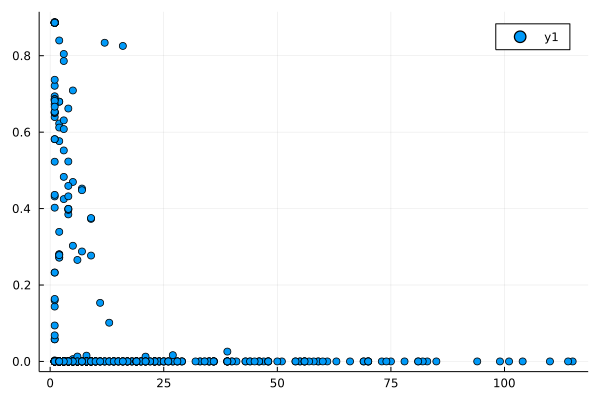

In [53]:
scatter(sensors_per_group.n_stations, sensors_per_group.p)

In [63]:
# what about just doing some simpler indicators: county*urban and day of week
logit = glm(@formula(anymissing ~ postlockdown*(County + Lanes + urban + dayofweek + month)), model_data, Binomial(), LogitLink(), contrasts=Dict(:Lanes=>DummyCoding()))

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

anymissing ~ 1 + postlockdown + County + Lanes + urban + dayofweek + month + postlockdown & County + postlockdown & Lanes + postlockdown & urban + postlockdown & dayofweek + postlockdown & month

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.   Std. Error       z  Pr(>|z|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                           1.38441     0.0154761     89.46    <1e-99   1.35408      1.41474
postlockdown                         -1.53573     0.0305163    -50.33    <1e-99  -1.59554     -1.47592
County                               -0.00289907  7.1

In [64]:
exp.(coef(logit))

32-element Vector{Float64}:
   3.992478898784556
   0.21529763599972568
   0.997105124603417
   0.9108083784655907
   0.6844101761139904
   0.5774993196187429
   0.6730834106809267
   0.7376909451236977
   0.7079419893198949
 193.97372650769108
   0.6962598920399643
   1.0161832885815023
   1.3876823522320938
   ⋮
   2.895226279029408
   3.001036737196719
   2.9165196698852363
   4.984954090110336
   4.490285894420935
   1.6099646568051877
   0.9823038096650657
   0.7014761949382989
   0.6401160166292689
   0.7033056366562501
   1.1996697076124492
   1.3471515000524141

### What about only completely missing data?

i.e. things Caltrans didn't impute. If we basically trust the imputations, then it doesn't matter that they changed in geographic location.

In [22]:
model_data.completelymissing = .!in.(model_data.missing_reason, [Set([:not_missing, :imputed_less_than_1hr, :imputed_1hr_or_more])])
@assert sort(unique(model_data[model_data.completelymissing, :missing_reason])) == [:insufficient_data, :no_traffic, :not_in_file]

In [23]:
# leaving year out due to collinearity with postpandemic, and also we don't differentiate prepandemic years in permutation test
completelymissing_logit = glm(@formula(completelymissing ~ postpandemic*(fwy_dir_group + dayofweek + month)), model_data, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

completelymissing ~ 1 + postpandemic + fwy_dir_group + dayofweek + month + postpandemic & fwy_dir_group + postpandemic & dayofweek + postpandemic & month

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                          Coef.   Std. Error       z  Pr(>|z|)      Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                                         -2.81526       0.122309   -23.02    <1e-99    -3.05499      -2.57554
postpandemic                                       -11.2441       51.764       -0.22    0.8280  -112.7          90.2114
fwy_dir_

With a false discovery rate of 0.05, we have 4 significant interaction terms - all temporal (days of week + month of June). Less of a concern, maybe? Although if occupancies differ over the days of the week, it could be problematic.

In [24]:
false_discovery_rate(completelymissing_logit, 0.05, subset=filter(c -> startswith(c, "postpandemic &"), coefnames(logit)))

4-element Vector{String}:
 "postpandemic & dayofweek: Monday"
 "postpandemic & month: June"
 "postpandemic & dayofweek: Wednesday"
 "postpandemic & dayofweek: Tuesday"

In [25]:
# Compute pseudo-R2 for our logit model
function loglikelihood_const(model, data, family, link)
    full_form = formula(model)
    constant_form = full_form.lhs ~ ConstantTerm(1)
    constmodel = glm(constant_form, data, family, link)
    return loglikelihood(constmodel)    
end

ll_β = loglikelihood(logit)
ll_const = loglikelihood_const(logit, model_data, Binomial(), LogitLink())

# McFadden's adjusted pseudo R2 - https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/
1 - ((ll_β - length(coefnames(logit))) / ll_const)

0.09366201153504439

## Nearest-neighbor imputation

Avoid potential issues with their imputation method by just replacing all missing values with value from nearest nonmissing sensor.

In [26]:
# use the data with all values filled in
data = model_data
nothing

In [27]:
distance_matrix = KFactors.get_distance_matrix("../data/sensor_meta_geo.csv")
nothing

In [28]:
# ensure we can't possibly replace an imputed value with another imputed value
data.complete_peak_hour_occ = ifelse.(data.missing_reason .== :not_missing, data.peak_hour_occ, [missing])
nothing

In [29]:
@assert all(data[.!ismissing.(data.complete_peak_hour_occ), :missing_reason] .== :not_missing)

In [30]:
function find_nearest_values(distance_matrix, full_data, col)
    data = full_data[.!ismissing.(@view full_data[:, col]) .& .!coalesce(isnan.(@view full_data[:, col]), [false]) .& (full_data.periods_imputed .== 0), :]
    return (stations, date) -> begin
        station = stations[1]
        nearest_stations = @view distance_matrix[distance_matrix.from_sensor .== station, [:to_sensor, :distance]]
        @assert issorted(nearest_stations.distance)
        return map(date) do date
            sensors_for_date = @view data[(data.date .== date), :]
            for to_sensor in nearest_stations.to_sensor
                sel = (sensors_for_date.station .== to_sensor)
                if any(sel)
                    return sensors_for_date[sel, col][1]
                end
            end
            return missing
        end
    end
end

find_nearest_values (generic function with 1 method)

In [31]:
# find nearest-neighbor value for every obs
transform!(groupby(data, :station), [:station, :date] => find_nearest_values(distance_matrix, data, :complete_peak_hour_occ) => :nearest_occ)

,station,date,peak_hour_occ,occ_entropy,total_occ,total_flow,station_type
,Int64,Date,Float64?,Float64?,Float64?,Int64?,String?
1,312010,2016-06-21,0.0993812,5.47138,30.0741,124445,ML
2,312098,2016-06-21,0.196265,5.27631,16.2056,76301,ML
3,312103,2016-06-21,0.10535,5.38137,26.3512,108967,ML
4,312132,2016-06-21,0.0794718,5.5217,12.987,27555,ML
5,312133,2016-06-21,0.250706,5.21355,17.1021,39827,ML
6,312134,2016-06-21,0.128285,5.48288,21.2293,37094,ML
7,312139,2016-06-21,0.105051,5.42806,28.2015,129293,ML
8,312326,2016-06-21,0.074277,5.473,13.1804,34305,ML
9,312346,2016-06-21,0.0796166,5.47493,15.2732,65477,ML


In [32]:
data.imputed_occ = ifelse.(data.missing_reason .== :not_missing, data.complete_peak_hour_occ, data.nearest_occ)
nothing

In [33]:
# many still missing - the fwy/direction pair had no other observations
mean(ismissing.(data.imputed_occ))

0.10341716148562115

In [34]:
pmiss = combine(groupby(data, [:Fwy, :Dir, :date]), 
    nrow => :n_sensordays,
    :missing_reason => (x -> mean(x .!= :not_missing)) => :pct_missing)
sum(pmiss[pmiss.pct_missing .== 1, :n_sensordays]) / sum(pmiss.n_sensordays)

0.10341716148562115

In [35]:
transform!(groupby(data, [:Fwy, :Dir, :date]), 
    nrow => :n_sensordays,
    :missing_reason => (x -> mean(x .!= :not_missing)) => :pct_missing)
nothing

In [36]:
data[(ismissing.(data.nearest_occ) .& (data.pct_missing .< 1)), :]

,station,date,peak_hour_occ,occ_entropy,total_occ,total_flow,station_type
,Int64,Date,Float64?,Float64?,Float64?,Int64?,String?
1,314521,2016-06-21,0.148004,5.25096,7.8275,21466,ML
2,316482,2016-06-21,0.0858029,5.34587,1.9673,4009,ML
3,401144,2016-06-21,0.0860721,5.47871,10.8688,40733,ML
4,772396,2016-06-21,0.092791,5.48967,10.6519,21022,ML
5,772410,2016-06-21,0.091735,5.44187,11.2498,23459,ML
6,774373,2016-06-21,0.128163,5.48455,23.7097,121536,ML
7,1052910,2016-06-21,0.0977512,5.20487,7.9375,3058,ML
8,10102710,2016-06-21,0.0709139,5.44936,3.7059,8902,ML
9,10102810,2016-06-21,0.0901016,5.44256,4.4472,12521,ML


In [ ]:
# perform permutation test
# protective copy
imputed_data = data[in.(data.period, [Set(["prepandemic", "postpandemic"])]) .&
    .!ismissing.(data.imputed_occ), :]
# hardwired inside KFactors to use peak_hour_occ
imputed_data.peak_hour_occ = imputed_data.imputed_occ

permutation_test(imputed_data)

(ptest = -0.006880463055556368, pval = 0.0, n_sensors = 8146)

In [ ]:
sum(ismissing.(imputed_data.peak_hour_occ))

## 